# Regresi√≥n

Importamos librerias a utilizar

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import sklearn as sk
import matplotlib.pyplot as plt
from six import StringIO
from IPython.display import Image  
import pickle
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

Importamos las bases de datos a utilizar

In [2]:
ds_properati = pd.read_csv('dataset_properati_train.csv')
ds_properati_test = pd.read_csv('dataset_properati_test.csv')
ds_reducido_train_sin_precio = pd.read_csv("dataset_reducido_sin_price.csv")
ds_reducido_test_sin_precio = pd.read_csv("dataset_reducido_sin_price_test.csv")

ds_reducido_train_sin_precio.drop(columns='Unnamed: 0', inplace=True)
ds_reducido_test_sin_precio.drop(columns='Unnamed: 0', inplace=True)

Armamos el conjunto de train y test a partir del primer database

In [3]:
x_train = ds_properati.drop(['property_price'], axis='columns', inplace=False)
y_train = ds_properati.property_price.copy()

x_test = ds_properati_test.drop(['property_price'], axis='columns', inplace=False)
y_test = ds_properati_test.property_price.copy()

### M√©tricas en regresi√≥n
- MSE (Mean Square Error o error cuadr√°tico medio)
    Medida de qu√© tan cercana es la recta de regresi√≥n a los puntos que representan los datos. Mientras m√°s chico m√°s cerca est√° nuestro modelo de los datos reales. Al ser un valor elevado al cuadrado, es sensible a valores de diferencias grandes.
    
    $MSE= \frac{1}{n}\sum_{i=1}^n  (y_i'-y_i)^2$
- RMSE (Root Mean Square Error o ra√≠z del error cuadr√°tico medio)
    
    Tiene las mismas unidades que los valores representados en el eje vertical. Es la distancia de un punto hasta la recta de regresi√≥n, medida en l√≠nea recta. Mide el desv√≠o est√°ndar (cu√°nto se alejan los valores de la media).
    
    $RMSE= \sqrt{\frac{1}{n}\sum_{i=1}^n  (y_i'-y_i)^2}$
- R¬≤
    Es la proporci√≥n de variabilidad explicada por el modelo, se lo denomina coeficiente de determinaci√≥n.
    No depende de las unidades de medida y¬†**su valor est√° entre 0 y 1**¬†.
    Cuando¬†R¬≤¬†= 0 el modelo se ajusta poco a la varibilidad de los datos. Por el contrario¬†R¬≤¬†= 1 se ajusta mucho a la variabilidad de los datos.
    Mientras mayor, mayor es la fuerza de la/s variable/s regresora/s para predecir la variable respuesta. Mayor es la capacidad del modelo de explicar el fen√≥meno.
    
    $R^2=\frac{TSS-RSS}{TSS}$ .
    
- MAE (Mean Absolute Error o error medio absoluto)
    $MAE=\frac{1}{n}\sum_{i=1}^n  |y_i'-y_i|$



#### KNN


La l√≥gica de regresi√≥n KNN es muy similar a lo que se explic√≥ anteriormente para clasificaci√≥n.
El algoritmo KNN calcular√° la regresi√≥n para el conjunto de datos y luego tomar√° la cantidad K de vecinos, verificar√° los resultados de esos vecinos y promediar√° los resultados, generando una estimaci√≥n.

Primero observamos el mapa de correlacion para ver que variables pueden ser buenos features. 

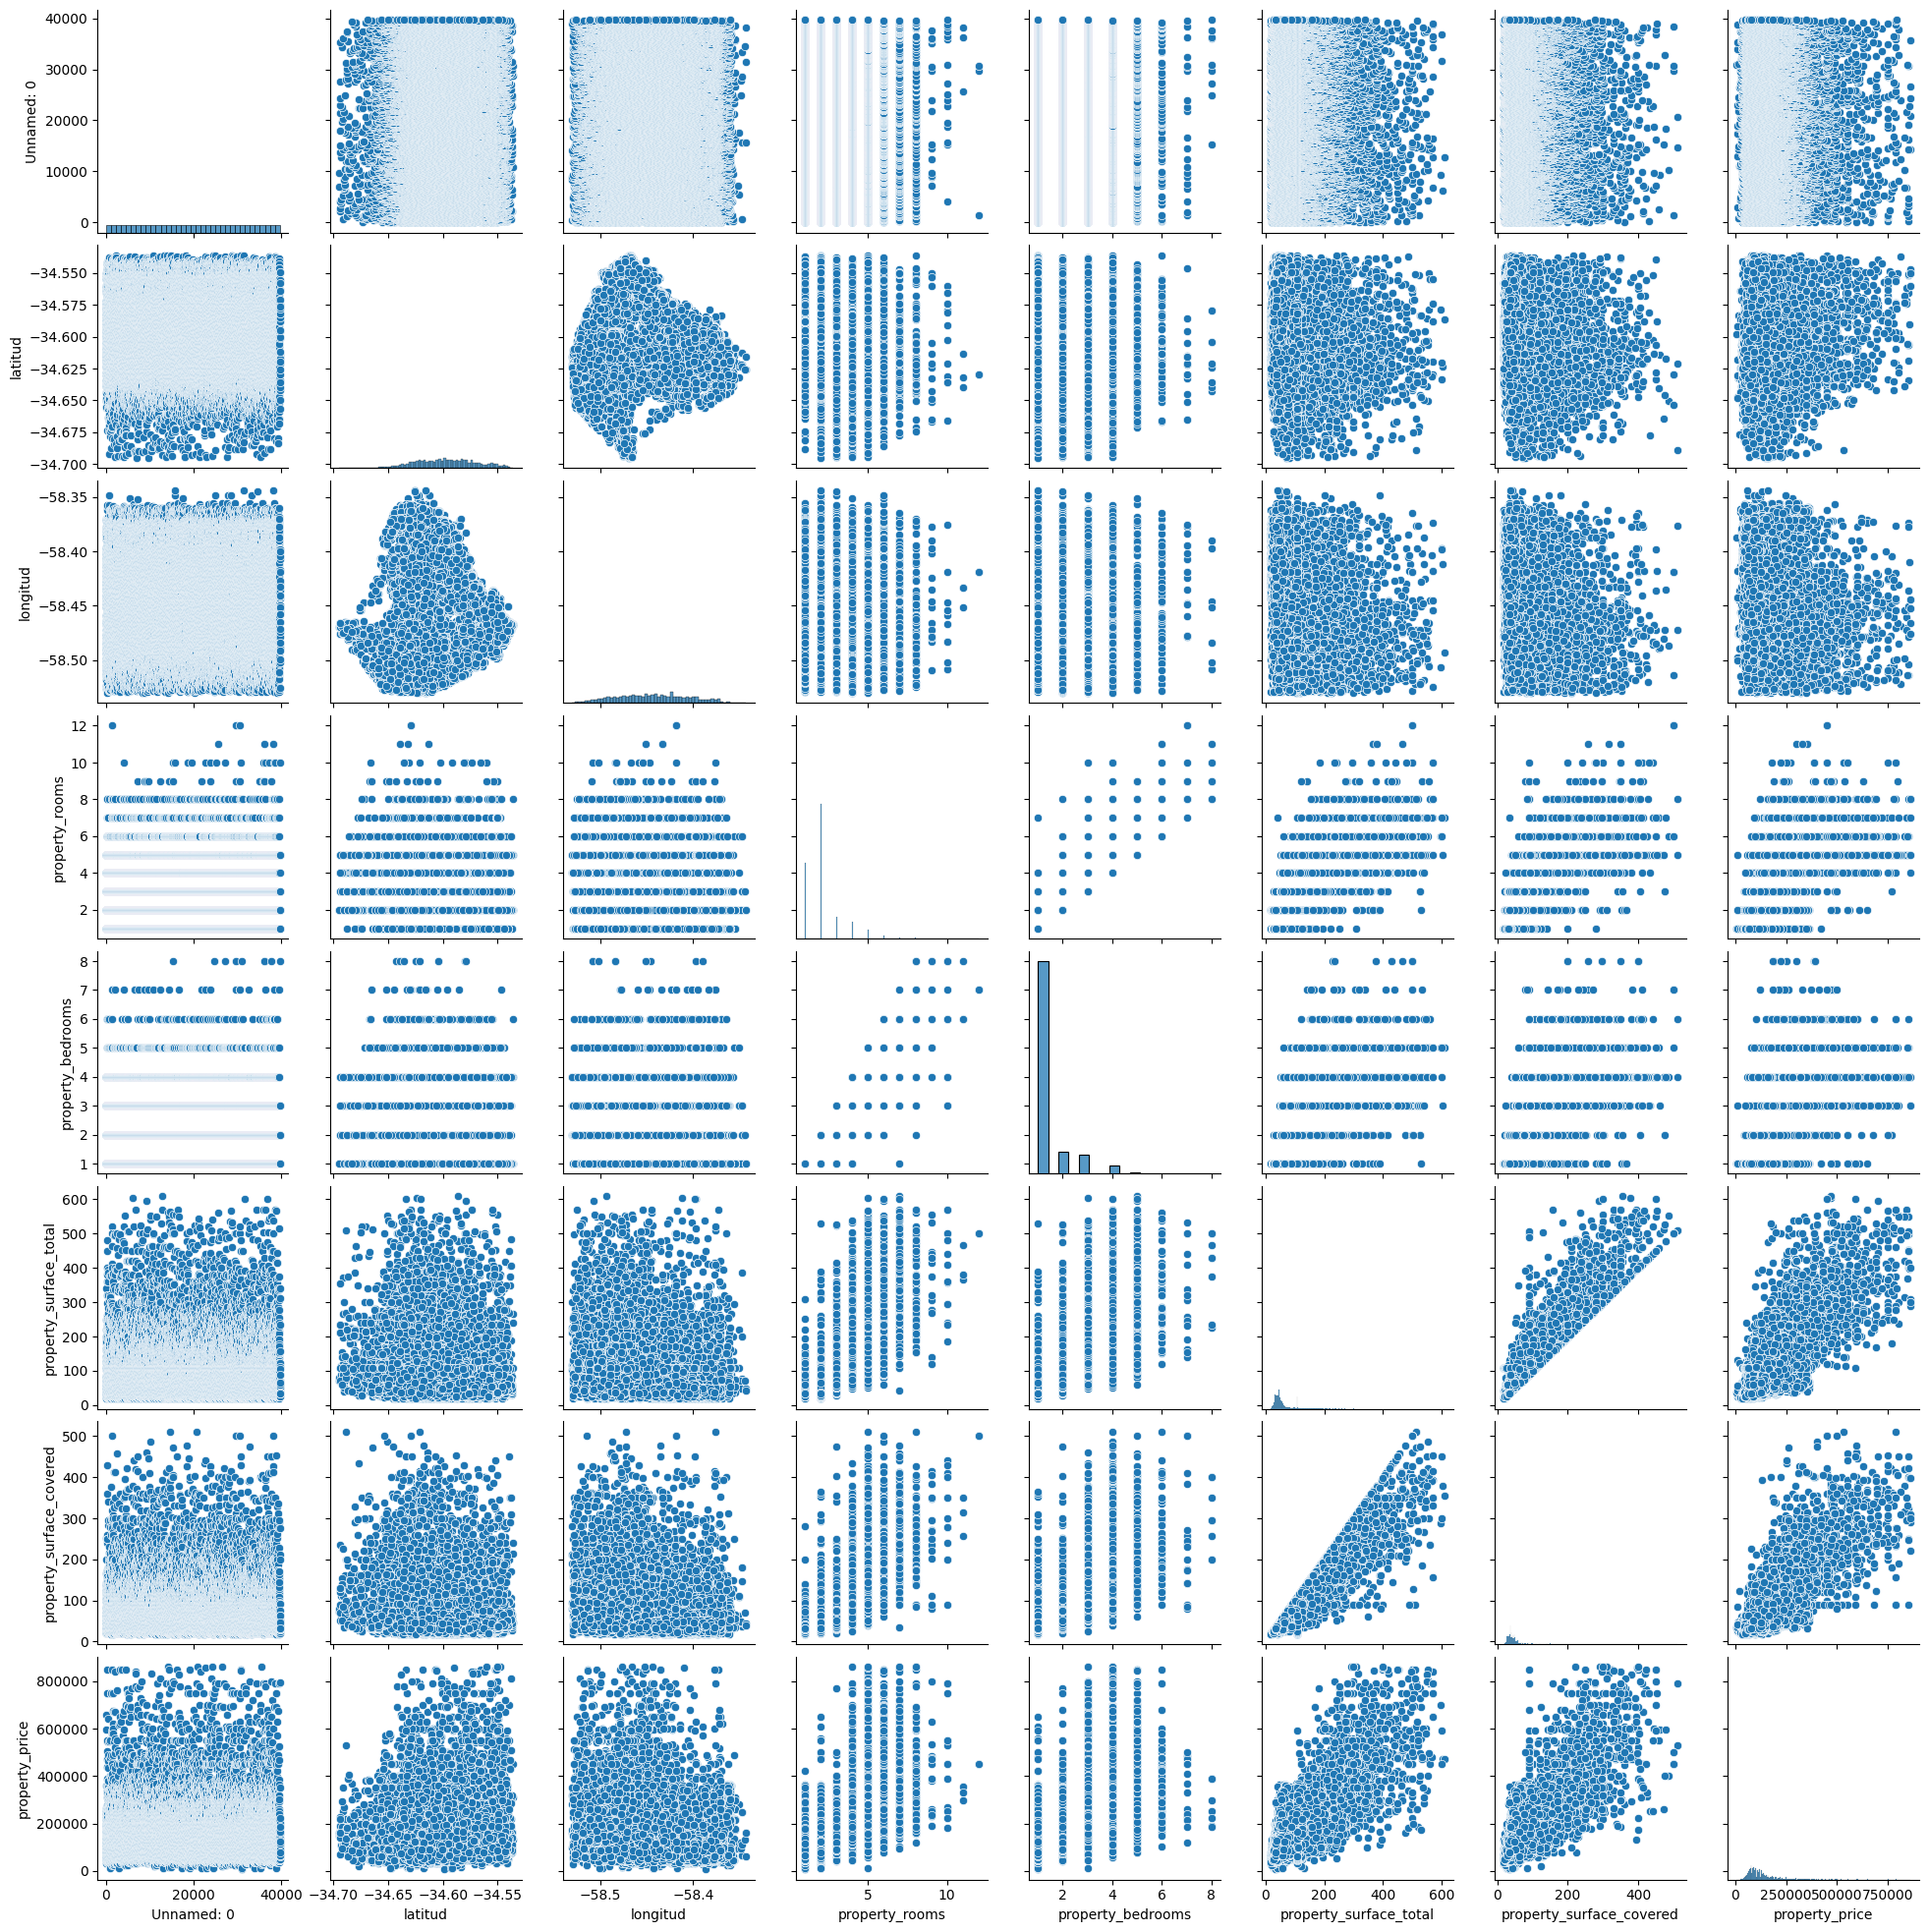

In [62]:
sns.pairplot(ds_properati)

In [5]:
#Heatmap de correlaci√≥n
ds_properati.corr().style.background_gradient(cmap='coolwarm')

Podemos ver que los atributos de property_surface_total y property_surface_covered podrian llegar a tener una relacion lineal con el precio.(0.78 y 0.81 de correlaci√≥n)

In [6]:
#seleccionamos las variables regresoras y hacemos una predicci√≥n
X = x_train[['property_surface_total','property_surface_covered']]
X_test = x_test[['property_surface_total','property_surface_covered']]
Y = y_train.copy()
Y_test = y_test.copy()

In [7]:
#Heatmap de correlaci√≥n
X.corr().style.background_gradient(cmap='coolwarm')

Vemos que las variables que podr√≠an ser regresoras est√°n muy correlacionadas entre s√≠.

<AxesSubplot: xlabel='property_surface_total', ylabel='property_price'>

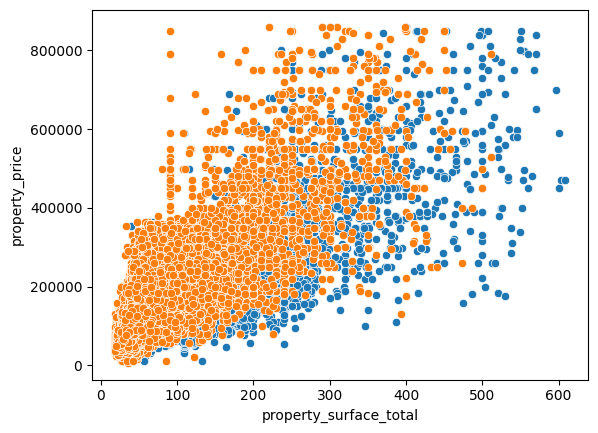

In [8]:
sns.scatterplot(x=X.property_surface_total,y=Y)
sns.scatterplot(x=X.property_surface_covered,y=Y)

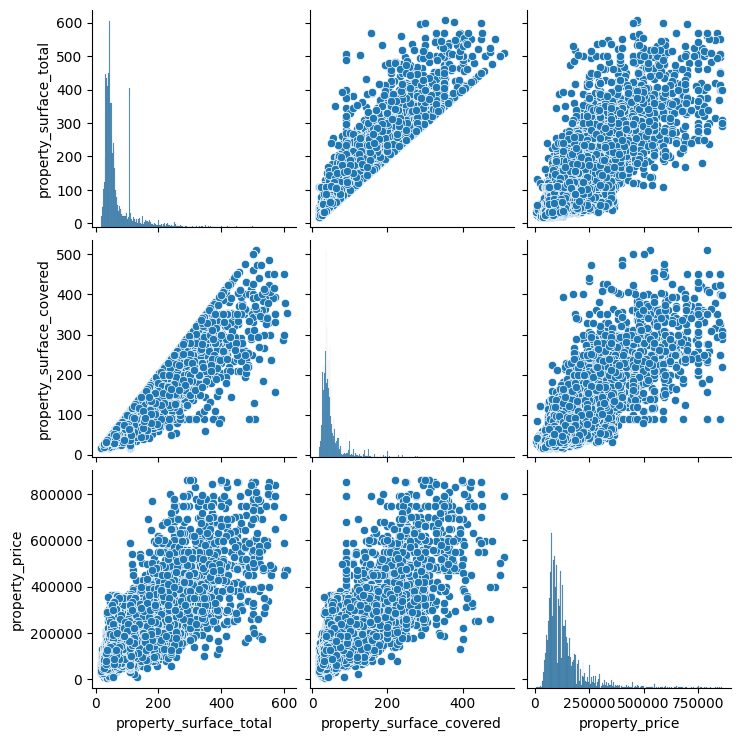

In [9]:
#Graficamos de a pares incluyendo la variable a predecir
xy_train = pd.concat([X, Y], axis=1)
sns.pairplot(xy_train)

Creamos un modelo KNN regresor ahora 

In [10]:
from sklearn.neighbors import KNeighborsRegressor

# Creamos el modelo KNN para regresion y lo ajustamos
knn_regressor = KNeighborsRegressor().fit(X, Y)

# Hacemos una predicci√≥n
y_pred=knn_regressor.predict(X_test)

Comparamos la performance del Clasificador Regresor

In [11]:
# Performance
performance = pd.DataFrame({'Valor Real': Y_test,
                            'Prediccion': y_pred,
                            'Error': abs(Y_test - y_pred)})
# View
performance.head(10)

Valor Real  Prediccion    Error
0    220000.0    259000.0  39000.0
1     90000.0     73180.0  16820.0
2     85000.0    103578.0  18578.0
3    144000.0    168000.0  24000.0
4    105000.0    101260.0   3740.0
5     45900.0     68028.0  22128.0
6    155000.0    136000.0  19000.0
7     89000.0    110800.0  21800.0
8     47000.0     55580.0   8580.0
9    134000.0    135700.0   1700.0

Observamos que tenemos un poco de error en las predicciones. Procedemos a buscar los mejores parametros

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition, datasets
from sklearn import neighbors
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

In [13]:
n_neighbors = [2, 3, 5, 10]
algorithm = ["auto",  "ball_tree", "kd_tree", "brute"]

parameters = {'weights':['uniform', 'distance'],
            'algorithm': algorithm,
                'n_neighbors': n_neighbors,
                'leaf_size': [20,22,23,30],
                'p' : [1,2],
                }

In [14]:
clf = RandomizedSearchCV(knn_regressor, parameters, random_state=2, scoring='r2')
clf.fit(X, Y)

RandomizedSearchCV(estimator=KNeighborsRegressor(),
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [20, 22, 23, 30],
                                        'n_neighbors': [2, 3, 5, 10],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=2, scoring='r2')

Usamos la m√©trica de R2 para hallar los mejores par√°metros porque nos da una explicaci√≥n general de la capacidad de predecir de un modelo. Va de 0 a 1, cuanto mas cerca de 1, es la fuerza de la/s variable/s regresora/s para predecir la variable respuesta. Esta es el score por default de KNN regresi√≥n.

In [15]:
print(); print("los mejores parametros son: ",clf.best_params_)

CV_Result = cross_val_score(clf, X, Y, cv=3, n_jobs=-1)
print(); print(CV_Result)
print(); print("la media es: ",CV_Result.mean())
print(); print("el desvio estandar es: ",CV_Result.std())


los mejores parametros son:  {'weights': 'distance', 'p': 1, 'n_neighbors': 10, 'leaf_size': 20, 'algorithm': 'brute'}

[0.68928975 0.69102199 0.67750698]

la media es:  0.6859395733470305

el desvio estandar es:  0.006004535227115078


Comparamos con el conjunto de entrenamiento

In [16]:
y_pred_train = clf.predict(X)

# Performance
performance = pd.DataFrame({'Valor Real': Y,
                            'Prediccion': y_pred_train,
                            'Error':abs(Y - y_pred_train) })
print(performance)

       Valor Real     Prediccion         Error
0         79000.0  114756.000000  35756.000000
1         99000.0  112136.500000  13136.500000
2        160000.0  169490.285714   9490.285714
3        153000.0  173990.000000  20990.000000
4        159000.0  137513.900000  21486.100000
...           ...            ...           ...
39714    126900.0   88380.000000  38520.000000
39715    185000.0  173000.000000  12000.000000
39716    795000.0  795000.000000      0.000000
39717    125000.0  190206.333333  65206.333333
39718     77000.0   73980.000000   3020.000000

[39719 rows x 3 columns]


Evaluamos las metricas en el conjunto de entrenamiento

In [17]:
from sklearn import metrics

# Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = Y,
        y_pred  = y_pred_train,
        squared = True                                                                                                                                                                                                                                                                                                                                                    
       )

print(f"El error (mse) de test es: {mse}")

# Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = Y,
        y_pred  = y_pred_train,
        squared = False
       )              

print(f"El error (rmse) de test es: {rmse}")

#Coef. de Determinaci√≥n R2
score_knn = clf.score(X, Y)
print("El score de train es: ",score_knn)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

El error (mse) de test es: 1201941233.5117552
El error (rmse) de test es: 34669.02412113377
El score de train es:  0.8405474856617435


Comparamos con el conjunto de test

In [18]:
y_pred_test = clf.predict(X_test)

# Performance
performance = pd.DataFrame({'Valor Real': Y_test,
                            'Prediccion': y_pred_test,
                            'Error':abs(Y_test - y_pred_test) })
print(performance)

      Valor Real     Prediccion         Error
0       220000.0  232666.666667  12666.666667
1        90000.0   75486.100000  14513.900000
2        85000.0   91869.000000   6869.000000
3       144000.0  112229.232286  31770.767714
4       105000.0   93036.000000  11964.000000
...          ...            ...           ...
9861     85000.0  101700.000000  16700.000000
9862    275000.0  290000.000000  15000.000000
9863    143900.0  127050.000000  16850.000000
9864    139500.0  132800.000000   6700.000000
9865    300000.0  274390.000000  25610.000000

[9866 rows x 3 columns]


In [19]:
#Exportamos el modelo
knn = 'models/knn_regresion.sav'
pickle.dump(clf, open(knn, 'wb'))

Evaluamos las m√©tricas en el conjunto de test

In [20]:
from sklearn import metrics

#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = Y_test,
        y_pred  = y_pred_test,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = Y_test,
        y_pred  = y_pred_test,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

#Coef. de Determinaci√≥n R2
score_knn = clf.score(X_test, Y_test)

print("El score de test es de: ",score_knn)

El error (mse) de test es: 2304339471.31404
El error (rmse) de test es: 48003.53602927643
El score de test es de:  0.6815854642430188


El score dio mucho menos en test que train (0.8 vs 0.7)

Vamos a entrenar el modelo sobre el ds reducido con PCA en el que eliminamos la variable target (property_price):

In [28]:
knn_pca = knn_regressor.fit(ds_reducido_train_sin_precio, Y)
y_pca_train = knn_pca.predict(ds_reducido_train_sin_precio)
y_pca_test = knn_pca.predict(ds_reducido_test_sin_precio)

In [31]:
# Exportamos el modelo sobre el ds reducido
file = 'models/knn_regresion_reducido.sav'
pickle.dump(knn_pca, open(file, 'wb'))

Evaluamos las m√©tricas para train

In [32]:
from sklearn import metrics

# Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = Y,
        y_pred  = y_pca_train,
        squared = True)

print(f"El error (mse) de train es: {mse}")

# Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = Y,
        y_pred  = y_pca_train,
        squared = False
       )
       
print(f"El error (rmse) de train es: {rmse}")

# Coef. de Determinaci√≥n R2
score_knn = knn_pca.score(ds_reducido_train_sin_precio, y_pca_train)
print("El score es de: ",score_knn)

El error (mse) de train es: 974975059.3466823
El error (rmse) de train es: 31224.590619360926
El score es de:  1.0


Y para test

In [33]:
from sklearn import metrics

# Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = Y_test,
        y_pred  = y_pca_test,
        squared = True)

print(f"El error (mse) de test es: {mse}")

# Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = Y_test,
        y_pred  = y_pca_test,
        squared = False
       )
       
print(f"El error (rmse) de test es: {rmse}")

# Coef. de Determinaci√≥n R2
score_knn = knn_regressor.score(ds_reducido_test_sin_precio, y_pca_test)
print("El score es de: ",score_knn)


El error (mse) de test es: 1552976891.3829637
El error (rmse) de test es: 39407.827793256554
El score es de:  1.0


### XG BOOST

XGBoost es una forma m√°s regularizada de Gradient Boosting . XGBoost utiliza la regularizaci√≥n avanzada (L1 y L2), que mejora las capacidades de generalizaci√≥n del modelo.

Ofrece un alto rendimiento en comparaci√≥n con Gradient Boosting. Su entrenamiento es muy r√°pido y se puede paralelizar entre cl√∫steres.

Fue dise√±ado para Big Data, es decir para conjuntos de datos grandes y complejos.

XG Boost puede usarse para problemas de regresi√≥n o de clasificaci√≥n.

Pasos:



1. Hacer una predicci√≥n inicial. Esta predicci√≥n puede ser cualquier valor.
2. Construir un √°rbol para los residuos. Este √°rbol es diferente a los usados por Gradient Boost. Primero se crea un nodo hoja y se ponen all√≠ **todos** los residuos.
3. Calcular el ***Similarity Score***, para los residuos: $Similarity Score=\frac{(\sum{residuos)^2}}{\#residuos + \lambda}$
4. Tenemos que ver cu√°l ser√° el siguiente nodo. Para ello vamos a calcular la **ganancia total** (Gain), seg√∫n escojamos una opci√≥n u otra para partir el √°rbol (qu√© umbral tomemos). Nos quedamos con el umbral que de la mayor informaci√≥n ganada.
5. Repetimos el anterior hasta alcanzar la profundidad del √°rbol estipulada.
6. Poda:
    - Elegimos un n√∫mero al azar ‚Üí este n√∫mero se llama gamma ( **ùú∏** )
    - Calculamos la diferencia entre el **Gain** del nodo m√°s bajo y **gamma**
    - Si la diferencia es < 0 ‚Üí removemos el nodo
    - Sino, el nodo se queda y se termin√≥ la poda
7. Volvemos a calcular el √°rbol (repite paso 3), solo que esta vez usamos lambda ùõå igual a 1 al calcular el Similarity Score y el Gain.
8. Podamos (paso quinto nuevamente).
9. Con estos nuevos residuos, construimos un nuevo √°rbol.
Repetimos todo, desde el paso 2.
Con el nuevo √°rbol, calculamos la salida de cada elemento y luego los residuos.
Construimos otro √°rbol.
Seguimos hasta que los residuos son pr√°cticamente cero o bien alcanzamos el n√∫mero m√°ximo de √°rboles predefinido.

 Hiper-par√°metros

learning_rate: tasa de aprendizaje

max_depth: m√°xima profundidad de cada √°rbol

subsample: porcentaje de muestras usadas para cada √°rbol (valor muy bajo, posible underfitting)

colsample_bytree: porcentaje de features usadas para cada √°rbol (valores muy alto, posible overfitting)

n_estimators: cantidad de √°rboles a construir.

objective: funci√≥n de error a utilizar (algunas: reg:linear para regresi√≥n, reg:logistic, binary:logistic para clasificaci√≥n)

Par√°metros de regularizaci√≥n:

gamma: umbral para hacer split basado en la reducci√≥n de error de hacer el nuevo split.

alpha: regularizaci√≥n para los pesos de las hojas. Un valor m√°s alto genera una mayor regularizaci√≥n.

lambda: similar alpha pero para la sintonia fina.

Los parametros se agregan al modelo para evitar el overfitting



Creamos el modelo

In [34]:
!pip install xgboost==1.6.2

  Using cached xgboost-1.6.2-py3-none-manylinux2014_x86_64.whl (255.9 MB)
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.7.0
    Uninstalling xgboost-1.7.0:
      Successfully uninstalled xgboost-1.7.0
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [35]:
ds_properati = pd.read_csv('dataset_properati_train.csv')
ds_properati_test = pd.read_csv('dataset_properati_test.csv')

x_train = ds_properati.drop(['property_price'], axis='columns', inplace=False)
y_train = ds_properati.property_price.copy()

x_test = ds_properati_test.drop(['property_price'], axis='columns', inplace=False)
y_test = ds_properati_test.property_price.copy()

X = x_train[['property_surface_total','property_surface_covered']]
X_test = x_test[['property_surface_total','property_surface_covered']]
Y = y_train.copy()
Y_test = y_test.copy()

In [36]:
X.columns

Index(['property_surface_total', 'property_surface_covered'], dtype='object')

In [37]:
#Creamos el modelo y lo entrenamos
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

xgb_model = xgb.XGBRegressor(random_state=0, n_estimators=100)
xgb_model.fit(X, Y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Evaluamos sobre el conjunto de entrenamiento

In [38]:
y_pred_train=xgb_model.predict(X)

Ahora evaluamos sobre el conjunto de test para observar su prediccion

In [39]:
y_pred_test=xgb_model.predict(X_test)

Calculamos el error para cada predicci√≥n:

In [40]:
score_train = xgb_model.score(X, Y)  
print("Score de training: ", score_train)
score_test = xgb_model.score(X_test,Y_test)
print("Score de test: ", score_test)

ypred_train = xgb_model.predict(X)
mse_train = mean_squared_error(Y, ypred_train)
print("MSE train: %.2f" % mse_train)
print("RMSE train: %.2f" % (mse_train**(1/2.0)))
ypred_test = xgb_model.predict(X_test)
mse_test = mean_squared_error(Y_test, ypred_test)
print("MSE test: %.2f" % mse_test)
print("RMSE test: %.2f" % (mse_test**(1/2.0)))


Score de training:  0.7880161858133388
Score de test:  0.6795699002470665
MSE train: 1597918277.84
RMSE train: 39973.97
MSE test: 2318925940.06
RMSE test: 48155.23


Vemos que obtienen valores similares para los dos conjuntos. Por un lado, mientras mas cerca a 1 es el score, mejor fitea la linea de regresion a los datos, y por ende mejor modelo.

Ahora optimizamos los hiperparametros a trav√©s de KFold cross validation con 5 folds con la metrica Mean Absolute Error

In [41]:
from sklearn.metrics import mean_absolute_error
params = {
    'n_estimators':[50, 20],
    'min_child_weight':[4,5], 
    'gamma':[i/10.0 for i in range(3,4)],  
    'subsample':[i/10.0 for i in range(6,8)],
    'colsample_bytree':[i/10.0 for i in range(6,8)], 
    'max_depth': [2,4,7],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': [mean_absolute_error],
    'eta': [i/10.0 for i in range(3,4)],
}

reg = xgb.XGBRegressor(nthread=-1, random_state=2)

# run randomized search

random_search = RandomizedSearchCV(reg, param_distributions=params,
                                    cv=5, scoring='neg_mean_squared_error', random_state=2)

random_search.fit(X, y_train)


[17:28:29] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:28:29] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:28:29] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                   param_distributions={'booster': ['gbtree', 'gblinear'],
                                        'colsample_bytree': [0.6, 0.7],
                                        'eta': [0.3],
                                        'eval_metric': [<function mean_absolute_error at 0x7fc248445820>],
                                        'gamma': [0.3], 'max_depth': [2, 4, 7],
                                        'min_child_weight': [4, 5],
                                        'n_estimators': [50, 20],
                                        'objective': ['reg:squarederror',
                                                      'reg:tweedie'],
                                        'subsample': [0.6, 0.7]},
                   random_state=2, scoring='neg_mean_squared_error')

In [42]:
display(random_search.best_params_)
xgbmodel_cv = random_search.best_estimator_

{'subsample': 0.6,
 'objective': 'reg:tweedie',
 'n_estimators': 50,
 'min_child_weight': 5,
 'max_depth': 2,
 'gamma': 0.3,
 'eval_metric': <function sklearn.metrics._regression.mean_absolute_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'eta': 0.3,
 'colsample_bytree': 0.6,
 'booster': 'gbtree'}

Estos serian los mejores parametros para xgboost

Ahora hacemos predicciones con los conjuntos y evaluamos la performance

In [43]:
y_train_pred_cv = xgbmodel_cv.predict(X)
y_test_pred_cv = xgbmodel_cv.predict(X_test)

In [44]:
# Exportamos el modelo
xgb = 'models/xgb_regressor.sav'
pickle.dump(xgbmodel_cv, open(xgb, 'wb'))

In [45]:
score_train = xgbmodel_cv.score(X, Y)  

print("Score de training: ", score_train)
score_test = xgbmodel_cv.score(X_test,Y_test)
print("Score de test: ", score_test)
mse_train = mean_squared_error(Y, y_train_pred_cv)
mse_test = mean_squared_error(Y_test, y_test_pred_cv)
print("MSE train: %.2f" % mse_train)

print("MSE test: %.2f" % mse_test)
print("RMSE test: %.2f" % (mse_test**(1/2.0)))
print("RMSE train: %.2f" % (mse_train**(1/2.0)))

Score de training:  0.7008344928604124
Score de test:  0.6712008652329962
MSE train: 2255087416.89
MSE test: 2379491949.31
RMSE test: 48780.04
RMSE train: 47487.76


Aunque entrenamos el modelo con la metrica de RMSE y ahora con MSE, no observamos mejora por sobre el score del train y test.

XGBoost tiene tambi√©n m√©tricas para evaluar, RMSE, MSE y R2 que ya las explicamos arriba. Explicamos las dem√°s:

- El error porcentual absoluto medio (MAPE), tambi√©n conocido como desviaci√≥n promedio absoluta porcentual (MAPD), mide la exactitud de un m√©todo para la construcci√≥n ajustada de valores de serie de tiempo en estad√≠sticas. Con la formula


![Picture title](image-20221101-214052.png)

- Error: Calculado como mal predichas / total de casos

Entrenamos el modelo con el set reducido por PCA:

In [46]:
xgb_red = xgbmodel_cv.fit(ds_reducido_train_sin_precio, y_train)
y_pred_pca_train = xgb_red.predict(ds_reducido_train_sin_precio)
y_pred_pca_test = xgb_red.predict(ds_reducido_test_sin_precio)

In [47]:
# Exportamos el modelo sobre el ds de pca
xgb = 'models/xgb_regressor_reducido.sav'
pickle.dump(xgb_red, open(xgb, 'wb'))

Observamos las metricas con el conjunto de train y test del ds reducido

In [48]:
score_pca_train = xgbmodel_cv.score(ds_reducido_train_sin_precio, Y)
print("Score de training: ", score_train)
score_test = xgbmodel_cv.score(ds_reducido_test_sin_precio,Y_test)
print("Score de test: ", score_test)
mse_train = mean_squared_error(Y, y_train_pred_cv)
mse_test = mean_squared_error(Y_test, y_test_pred_cv)
print("MSE train: %.2f" % mse_train)

print("MSE test: %.2f" % mse_test)
print("RMSE test: %.2f" % (mse_test**(1/2.0)))
print("RMSE train: %.2f" % (mse_train**(1/2.0)))

Score de training:  0.7008344928604124
Score de test:  0.6938756896729701
MSE train: 2255087416.89
MSE test: 2379491949.31
RMSE test: 48780.04
RMSE train: 47487.76


### Gradient Boost

Gradient Boost puede usarse para problemas de regresi√≥n o de clasificaci√≥n.

Gradient Boost comienza con un nodo hoja, luego construye √°rboles pero de m√°s de un nivel y todos aportan lo mismo a la clasificaci√≥n final (no tienen pesos). Se construyen tantos √°rboles como se solicite o hasta que los √°rboles adicionales no logren mejorar el ajuste.

Permite elegir una funci√≥n de costo L, por ejemplo, error cuadr√°tico medio si es un problema de regresi√≥n y cada √°rbol que construye lo hace de manera que la funci√≥n de costo se minimice (t√©cnica de optimizaci√≥n que se denomina descenso por gradiente).

En cada iteraci√≥n construimos un √°rbol nuevo que aprenda a predecir el residuo (error) entre las observaciones y los valores predichos por el √°rbol anterior.

Finalmente para estimar un nuevo valor, cuando el m√©todo termina de entrenar, procedemos como antes, usando el valor inicial y sumando los residuos ponderados (por un valor constante learning rate) de cada √°rbol.

Par√°metros espec√≠ficos del √°rbol: afectan a cada √°rbol individual del modelo.

- Criterio de elecci√≥n de atributos en cada nodo (ganancia de la informaci√≥n o gini)
- Criterio de parada (ej: m√°xima profundidad generalmente se usa 5 o 6)
- Estrategia de poda

Par√°metros de boosting: estos afectan la operaci√≥n de boosting en el modelo.

- learning_rate¬†(por defecto=0.1): la tasa de aprendizaje reduce la contribuci√≥n de cada √°rbol ‚Üí maneja el overfitting. Hay una compensaci√≥n entre learning_rate y la cantidad de estimadores. Es un valor entre 0 y 1. Tendr√° una varianza baja.
- n_estimators¬†(por defecto=100): cantidad de estimadores que se van a utilizar.

Importamos las librerias a usar en Gradient Boosting

In [49]:
!pip install xgboost==1.7.0

  Using cached xgboost-1.7.0-py3-none-manylinux2014_x86_64.whl (193.6 MB)
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.6.2
    Uninstalling xgboost-1.6.2:
      Successfully uninstalled xgboost-1.6.2
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [50]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

Construimos un modelo con el target. 

In [51]:
gb_model = GradientBoostingRegressor(random_state=2)
gb_model.fit(X, Y)

GradientBoostingRegressor(random_state=2)

In [52]:
# R¬≤ en train
print("Model Accuracy train: %.3f" % gb_model.score(X, Y))
mse = mean_squared_error(Y, gb_model.predict(X))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

Model Accuracy train: 0.716
The mean squared error (MSE) on test set: 2139015700.3037


Evaluamos el modelo en el conjunto de test

In [53]:
# R¬≤ 
print("Model Accuracy test: %.3f" % gb_model.score(X_test, Y_test))
mse = mean_squared_error(Y_test, gb_model.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

Model Accuracy test: 0.677
The mean squared error (MSE) on test set: 2335368492.9379


In [54]:
sk.metrics.get_scorer_names() #vemos las m√©tricas que podemos usar para entrenar con cv (s√≥lo las de regresi√≥n en este caso)

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

Intentamos optimizar hiperpar√°metros para obtener mejores resultados

In [55]:
# Par√°metros a optimizar
params_grid = {'n_estimators':range(20, 150, 5), 'max_depth':range(1,7), 'learning_rate':np.arange(0,1,0.001)}

# Folds
kfoldcv = StratifiedKFold(n_splits=5)

# Ramdom Search CV
randomcv = RandomizedSearchCV(GradientBoostingRegressor(random_state=2), params_grid, n_jobs=4, scoring='r2',cv=kfoldcv, n_iter=10,random_state=2,error_score='raise')
randomcv.fit(X,Y)

print(randomcv.best_params_)

# Mejor Modelo
gb = randomcv.best_estimator_

{'n_estimators': 145, 'max_depth': 5, 'learning_rate': 0.227}


In [56]:
# Hacemos la predicci√≥n en train y test
y_pred_train = gb.predict(X)
y_pred_test = gb.predict(X_test)

# Performance
performance = pd.DataFrame({'Valor Real': Y,
                            'Prediccion': y_pred_train,
                            'Error':abs(Y - y_pred_train) })
print(performance)

       Valor Real     Prediccion          Error
0         79000.0  117083.295082   38083.295082
1         99000.0  105749.450062    6749.450062
2        160000.0  154424.810404    5575.189596
3        153000.0  145392.004687    7607.995313
4        159000.0  133404.990765   25595.009235
...           ...            ...            ...
39714    126900.0   85241.932161   41658.067839
39715    185000.0  117361.855590   67638.144410
39716    795000.0  679170.115980  115829.884020
39717    125000.0  136896.151428   11896.151428
39718     77000.0   79687.049489    2687.049489

[39719 rows x 3 columns]


In [57]:
# M√©tricas sobre train y test
score_train_gb = gb.score(X, Y)
print("Score de training (R¬≤): ", score_train_gb)
score_test_gb = gb.score(X_test,Y_test)
print("Score de test (R¬≤): ", score_test_gb)
mse_train = mean_squared_error(Y, y_pred_train)
mse_test = mean_squared_error(Y_test, y_pred_test)
print("MSE train: %.2f" % mse_train)

print("MSE test: %.2f" % mse_test)
print("RMSE test: %.2f" % (mse_test**(1/2.0)))
print("RMSE train: %.2f" % (mse_train**(1/2.0)))

Score de training (R¬≤):  0.7826318867807627
Score de test (R¬≤):  0.6772725354018412
MSE train: 1638504724.83
MSE test: 2335551778.07
RMSE test: 48327.55
RMSE train: 40478.45


Si bien en train pasamos de 0.71 a 0.78 como score (medido como R¬≤) en test termina funcionando igual que el anterior con un 0.68

In [58]:
# Exportamos el modelo
gb_file = 'models/gb.sav'
pickle.dump(gb, open(gb_file, 'wb'))

In [59]:
# Entrenamos sobre el ds reducido
gb_pca = gb.fit(ds_reducido_train_sin_precio, Y)

# Evaluamos en train
y_pred_pca_train = gb_pca.predict(ds_reducido_train_sin_precio)

# Evaluamos en test
y_pred_pca_test = gb_pca.predict(ds_reducido_test_sin_precio)

In [60]:
# M√©tricas sobre train y test en el ds de pca
score_train_gb_pca = gb_pca.score(ds_reducido_train_sin_precio, Y)
print("Score de training (R¬≤): ", score_train_gb_pca)
score_test_gb_pca = gb_pca.score(ds_reducido_test_sin_precio,Y_test)
print("Score de test (R¬≤): ", score_test_gb_pca)
mse_train = mean_squared_error(Y, y_pred_pca_train)
mse_test = mean_squared_error(Y_test, y_pred_pca_test)
print("MSE train: %.2f" % mse_train)

print("MSE test: %.2f" % mse_test)
print("RMSE test: %.2f" % (mse_test**(1/2.0)))
print("RMSE train: %.2f" % (mse_train**(1/2.0)))

Score de training (R¬≤):  0.8642209793741582
Score de test (R¬≤):  0.7889844996639074
MSE train: 1023492192.73
MSE test: 1527101598.32
RMSE test: 39078.15
RMSE train: 31992.06


Asombrosamente vemos que trabajando con un ds mucho m√°s chico en columnas, las m√©tricas mejoran mucho porque no bajan tanto en test respecto a train como en el otro caso.

In [61]:
# Exportamos el modelo
gb_file_pca = 'models/gb_reducido.sav'
pickle.dump(gb_pca, open(gb_file_pca, 'wb'))

### Modelo que elegir√≠amos

Tomando en cuenta las m√©tricas de cada modelo:

KNN: El score R¬≤ es de: 0.6815854642430188

XGB: Score de test:  0.6684943411654958

GB: Score de test (R¬≤): 0.6772725354018412

Sin embargo, en el modelo entrenado con el data set reducido en Gradient Boost obtuvimos un score de test de 0.78742655711986, superior a todos los dem√°s modelos. 

Es por esto que este ser√≠a el modelo elegido para predecir el precio de una propiedad en CABA.



Adem√°s de esto, podemos notar que los errores elevados al cuadrado dan muy grandes en varios casos de los modelos predichos evaluados. Esto se podr√≠a dar con algunas propiedades de mayor valor, ya que el error podr√≠a ser mas despreciable ante n√∫meros tan elevados. Por otro lado, en el contexto de una casa con un precio normal, estos errores no deber√≠an de haber sido tan grandes dado que dichos errores podr√≠an contribuir a la clasificaci√≥n de una casa seg√∫n su rango de precios. Esto es por ejemplo en el caso de una casa con precio limite entre cara y media, al tener un error muy grande, se la podr√≠a considerar cara cuando no lo es.

## Conclusi√≥n final del trabajo

A lo largo del an√°lisis hecho sobre el dataset de propiedades de properati con el fin de construir un modelo que permita determinar si el precio de una propiedad es bajo, medio, o elevado, se logr√≥ hacer un an√°lisis completo del dataset como paso previo a la construcci√≥n del modelo, dicho an√°lisis debe ser realizado en todo trabajo de ciencia de datos. De igual forma al momento de construir el modelo, se probaron varias alternativas, determinando cu√°l de todas era la que resultaba de mayor utilidad. 

En el caso del trabajo realizado sobre el dataset de propiedades de properati se observaron varios aspectos relevantes, entre los que destacan:

- An√°lisis exploratorio: Se eliminaron varias columnas con una gran porcentaje de valores faltantes (como place_l5 o place_l6), se desconoce qu√© pod√≠an representar la mismas o si pod√≠an haber aportado informaci√≥n √∫til para la construcci√≥n del modelo. En cuanto al resto del an√°lisis exploratorio, no hay nada m√°s que destacar, pues se realizaron procedimientos comunes al mismo, tal como la imputaci√≥n por latitud en datos faltantes, o el uso de z-score para valores at√≠picos. 
- Agrupamiento: Se logr√≥ observar la tendencia al agrupamiento de variables del dataset, observ√°ndose la formaci√≥n de 3 grupos. La agrupaci√≥n fue visualizada en dispersogramas, siendo los dispersogramas relacionados con la superficie o los del precio de la propiedad los m√°s relevantes, pues mostraban clara agrupaci√≥n en posibles grupos de precio. Esto √∫ltimo dio un indicio sobre la utilidad de construir el modelo que determine tipos de precio (si es bajo, medio, o alto).
- Clasificaci√≥n: Durante el trabajo de clasificaci√≥n destac√≥ la construcci√≥n de una nueva variable, pxm2 (precio por metro cuadrado), la misma result√≥ de gran utilidad para determinar cuando el precio de una propiedad es de precio bajo, medio o alto, y en la construcci√≥n de la variable de inter√©s, tipo_precio. La construcci√≥n de la variable pxm2 se fundamenta en la importancia que tuvieron los metros cuadrados en la formaci√≥n de grupos (en el agrupamiento se logr√≥ visualizar que cuando se relacionaba el precio con alguna de las variables referidas a los metros cuadrado de las propiedades se ten√≠a un agrupamiento en los datos, quedando en evidencia la fuerte relaci√≥n entre el precio de una propiedad y sus metros cuadrados).
    De igual forma, destac√≥ la visualizaci√≥n de propiedades sobre un mapa de la Ciudad aut√≥noma de Buenos Aires de acuerdo a la variable al tipo_precio, en la que se observaron grupos de precio distribuidos en los distintos barrios de la ciudad. Las observaciones fueron en general las esperadas; propiedades de precios elevados en barrios como Puerto Madero o Recoleta, y propiedades de precio bajo en barrios de la zona sur de la ciudad.
    En cuanto a los modelos de clasificaci√≥n entre todos los modelos probados, se determin√≥ que el m√°s √∫til de todos es Random Forest.
- Regresi√≥n: Respecto a la regresi√≥n, los modelos obtenidos en esta parte tuvieron un mejor desempe√±o general que los de clafisicaci√≥n.

El resultado de todo esto fue la construcci√≥n del modelo m√°s adecuado para predecir cada target, aunque si bien algunas m√©tricas mostraron algunos problemas, el modelo fue construido con la informaci√≥n de la que se ten√≠a disposici√≥n y con los mejores resultados posibles.

En cuanto a la exploraci√≥n de nuevas opciones para el trabajo realizado y que quedaron fuera del alcance del mismo se encuentran el uso de variables del dataset como la fecha de publicaci√≥n (en la que se pudo haber buscado alguna relaci√≥n con el precio de la propiedad), la construcci√≥n de nuevas variables (la √∫nicas nuevas fueron pxm2 y tipo_precio), y el uso del dataset properati_argentina_2021_descrip.csv.



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fcb02109-3268-4805-81b4-1fba96795907' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>